In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from scipy.optimize import minimize, Bounds

from thesis.io import mesa, gyre, fgong
from thesis.physics import first_adiabatic_exponent, sound_speed, acoustic_depth, structure_kernels
from thesis.calculus import differentiate

from glitchpy.supportGlitch import smoothComponent, totalGlitchSignal 
from glitchpy.supportGlitch import fit

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [4]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [5]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


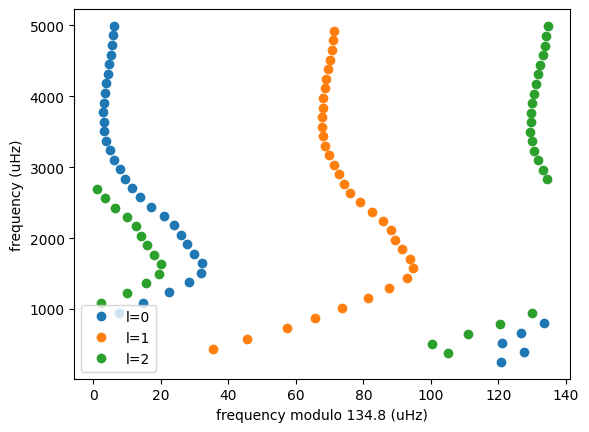

In [6]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

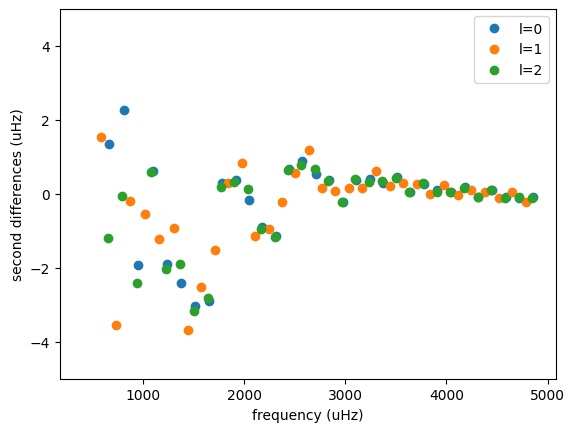

In [7]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [169]:
n = np.arange(11, 29)
num_of_l = 1
l = list(range(num_of_l))
stacked_data = data.sel(n_pg=n, l=l).stack(k=("l", "n_pg"))
freq = np.stack(
    [
        stacked_data.l.values,
        stacked_data.n_pg.values,
        stacked_data.freq.real.values,
        np.ones(stacked_data.freq.shape)
    ],
    axis=-1
)
freq = freq[~np.isnan(freq).any(axis=1)]

In [170]:
num_of_n = np.zeros(num_of_l, dtype=int)
for i in range (num_of_l):
    num_of_n[i] = len(freq[np.rint(freq[:, 0]) == i, 0])

Delta nu from linear fit to frequencies

In [171]:
coefs = np.polyfit(freq[freq[:, 0]<0.5, 1], freq[freq[:, 0]<0.5, 2], 1)
delta_nu = coefs[0]

In [172]:
param, chi2, reg, ier, ratio = fit(
    freq, num_of_n, delta_nu, n_rln=0, regu_param=7.0,
    tauhe=0.2*tau0.values, dtauhe=0.05*tau0.values,
    taucz=0.6*tau0.values, dtaucz=0.05*tau0.values,
)

In [173]:
func1d = lambda freq: smoothComponent(
    param[-1, :], l=freq[0].astype(int), n=freq[1].astype(int), num_of_n=num_of_n, npoly_params=5
)

In [174]:
nu_sm = np.apply_along_axis(func1d, 1, freq)
dnu = totalGlitchSignal(freq[:, 2], param[-1, :])
nu = nu_sm + dnu

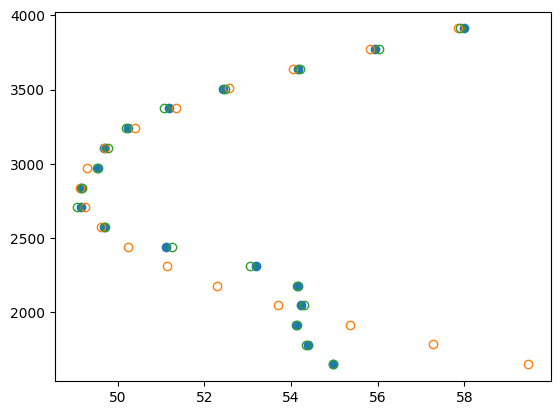

In [175]:
fig, ax = plt.subplots()

ax.plot(freq[:, 2]%delta_nu, freq[:, 2], "o")
ax.plot(nu_sm%delta_nu, nu_sm, "o", markerfacecolor="none")
ax.plot(nu%delta_nu, nu, "o", markerfacecolor="none")
# ax.set_xlim(50, 60)

In [176]:
nu_pred = np.linspace(freq[:, 2].min(), freq[:, 2].max(), 501)
dnu_pred = totalGlitchSignal(nu_pred, param[-1, :])

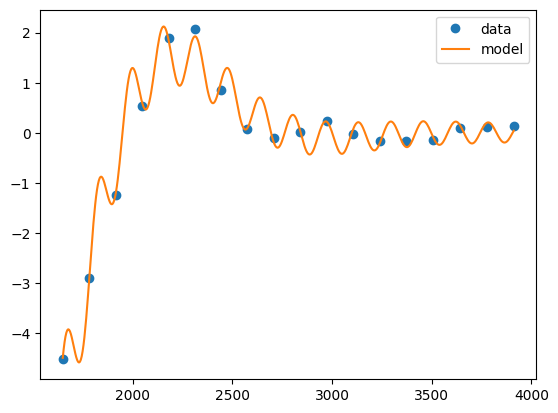

In [177]:
fig, ax = plt.subplots()
ax.plot(freq[:, 2], freq[:, 2] - nu_sm, "o", label="data")
ax.plot(nu_pred, dnu_pred, label="model")
ax.legend();

(array([2., 2., 1., 2., 1., 4., 2., 3., 0., 1.]),
 array([-0.13889528, -0.10978479, -0.08067429, -0.0515638 , -0.02245331,
         0.00665718,  0.03576767,  0.06487816,  0.09398865,  0.12309914,
         0.15220963]),
 [<matplotlib.patches.Polygon at 0x136fa37f0>])

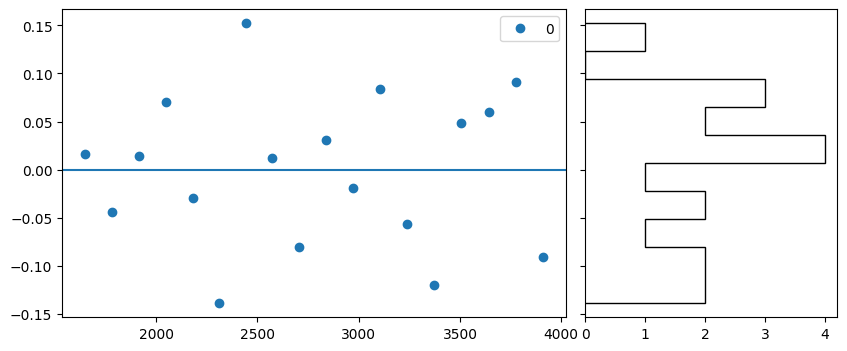

In [178]:
res = nu - freq[:, 2]
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True,
                         gridspec_kw={"wspace": 0.05, "width_ratios": [2, 1]})

ax = axes[0]
for l in range(num_of_l):
    mask = freq[:, 0] == l
    ax.plot(nu[mask], res[mask], "o", label=l)
    

ax.axhline()
ax.legend()

ax = axes[1]
ax.hist(res, orientation="horizontal", color="k", histtype="step")

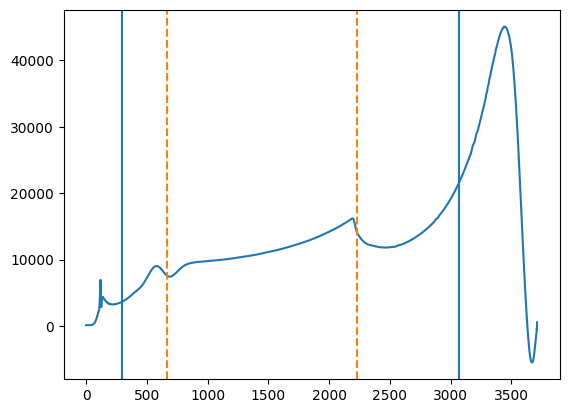

In [179]:
plt.plot(data.tau, differentiate(data.cs, data.tau))
plt.axvline(param[-1, -2])
plt.axvline(param[-1, -6])

plt.axvline(0.18*tau0, c="C1", ls="--")
plt.axvline(0.6*tau0, c="C1", ls="--")